# Kirkwood Gaps

There are many asteroids in our solar system between Mars and Jupiter.
The radial distribution of these asteroids has interesting structure.
Their distribution is heavily influenced, not only by the Sun, but by Jupiter too.

Here we will try to understand some aspects of this distribution, in particular the presence of particular orbital radii that are essentially excluded.

Things to think about:
- Transfer orbits
- Gravitational assist

Resources:
- This might be a useful code. https://rebound.readthedocs.io/en/latest/index.html

<img src="1552px-Kirkwood_Gaps.svg.png" width="800" height="200">

In [1]:
# FIX: all constants

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from IPython.display import Image

%matplotlib inline

In [4]:
# Collect relevant information about the Sun and Jupiter.

# Choose units
# distance - AU
# mass - units of solar mass
# time - years

# sun
m_sun = 1.0 # M_sun

# jupiter
m_jup= 0.0009543 # M_sun
orb_rad_jup = 5.2 # AU (between 4.9 and 5.4)
orb_T_jup = 11.862 # years


# Aphelion 816.62 million km (5.4588 AU)
# Perihelion	740.52 million km (4.9501 AU)


G = 39.478 # AU^3 / (year^2 M_sun)

In [5]:
# Let's assume the Sun is stationary.
# Assume orbits are coplanar.
# Assume orbits are the same direction.
# It would be fun to play with these assumptions later..

# Define a function (analytic, not MD) that describes Jupiter's orbit at any time.

def jupiter_orbit(t, orb_rad_jup=5.2, orb_T_jup=11.862):
    "Compute position of Jupiter at time t."
    
    omega = 2 * np.pi / orb_T_jup
    
    return 1.05*orb_rad_jup * np.cos(omega * t), 0.95*orb_rad_jup * np.sin(omega * t)

In [6]:
# Evolve the position of a test mass (an asteroid) that starts at radius 'r0'.
# Assign an initial velocity that *would* yield a circular orbit if not for the presence of Jupiter.
# Let's make use of scipy integrators

def asteroid_ode(t, pt, G=39.478, m_sun=1.0, m_jup=0.0009543):
    """
    return derivative
    d x / dt = v_x
    d y / dt = v_y
    d v_x / dt = a_x = (F_sun + F_jup)_x / m
    d v_y / dt = a_y = (F_sun + F_jup)_y / m
    
    let F = central gravitational force
    Note: force is velocity independent
    """    
    x, y, v_x, v_y = pt
    r = np.sqrt(x**2 + y**2) # distance to sun
    
    x_jup, y_jup = jupiter_orbit(t)
    r_jup = np.sqrt((x - x_jup)**2 + (y - y_jup)**2) # distance to Jupiter
    
    a_sun_mag = G * m_sun / r**2
    a_jup_mag = G * m_jup / r_jup**2
    #a_jup_mag = 0.0#G * m_jup / r_jup**2
    
    a_x = -a_sun_mag * x / r - a_jup_mag * (x - x_jup) / r_jup**2
    a_y = -a_sun_mag * y / r - a_jup_mag * (y - y_jup) / r_jup**2
    
    return v_x, v_y, a_x, a_y

In [7]:
def velocity_for_circular_orbit(r, G=39.478, m_sun=1.0):
    """
    a = v^2 / r
    a = F/m = GM/r^2
    therefore
    v = sqrt(GM/r)
    """
    return np.sqrt(G * m_sun / r)

In [100]:
# Integrate an asteroid orbit.
# TRY: Check out the behavior of a few of the different integrator `method' options. What do you observe?

t0 = 0
T = 1
Nt = 1000
r0 = 1.0
v0 = velocity_for_circular_orbit(r0)
pt0 = [r0, 0, 0, v0]
ts = np.linspace(t0, T, Nt)

# temporarily change this
# new_m_jup = 0.1

sol = integrate.solve_ivp(fun=asteroid_ode, args=(G, m_sun, m_jup), t_span=[t0, T], y0=pt0, t_eval=ts, method='RK45', rtol=10**-6)

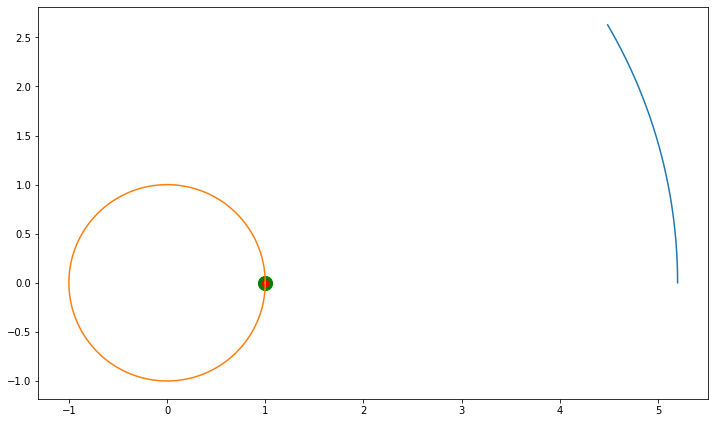

In [101]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

jup = [jupiter_orbit(t) for t in ts]
jup = np.array(jup)

plt.plot(jup[:, 0], jup[:, 1], '-')
plt.plot(sol.y[0, :], sol.y[1, :], '-')

plt.scatter(sol.y[0, 0], sol.y[1, 0], s=200, c='g')
plt.scatter(sol.y[0, -1], sol.y[1, -1], s=50, c='r')

ax.set_aspect('equal', 'box')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

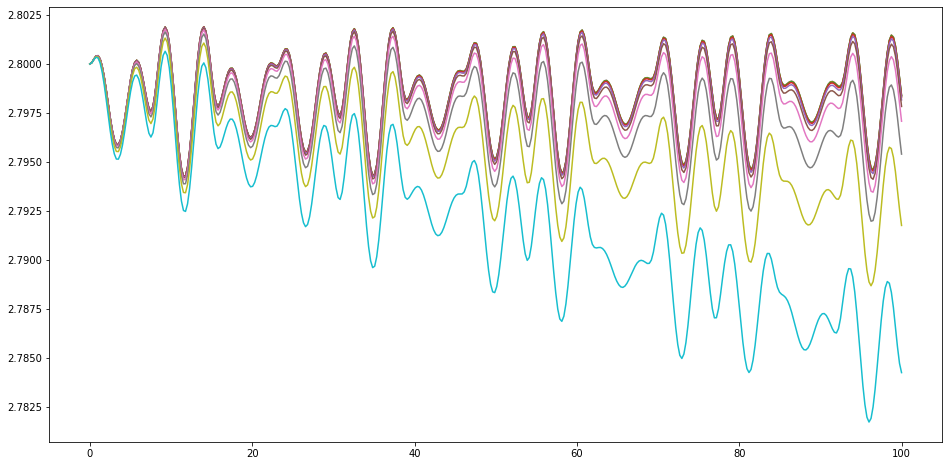

In [102]:
# TRY: Which integrator do you think we should use for this computation?
# TRY: Investigate the effect of atol and rtol on integration.

t0 = 0
T = 100
Nt = 400
r0 = 2.8
ts = np.linspace(t0, T, Nt)

tols = np.logspace(-7.0, -5.0, num=10)

fig = plt.figure(figsize=(16, 8))
ax = plt.gca()

for tind, tol in enumerate(tols):
    print(tind, end=', ')
    v0 = velocity_for_circular_orbit(r0)
    pt0 = [r0, 0, 0, v0]

    sol = integrate.solve_ivp(fun=asteroid_ode, t_span=[t0, T], y0=pt0, t_eval=ts, atol=tol, rtol=tol, method='RK45')
#     DOP853
    
    rads = [np.sqrt(sol.y[0, ind]**2 + sol.y[1, ind]**2) for ind in range(len(ts))]
    plt.plot(ts, rads)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

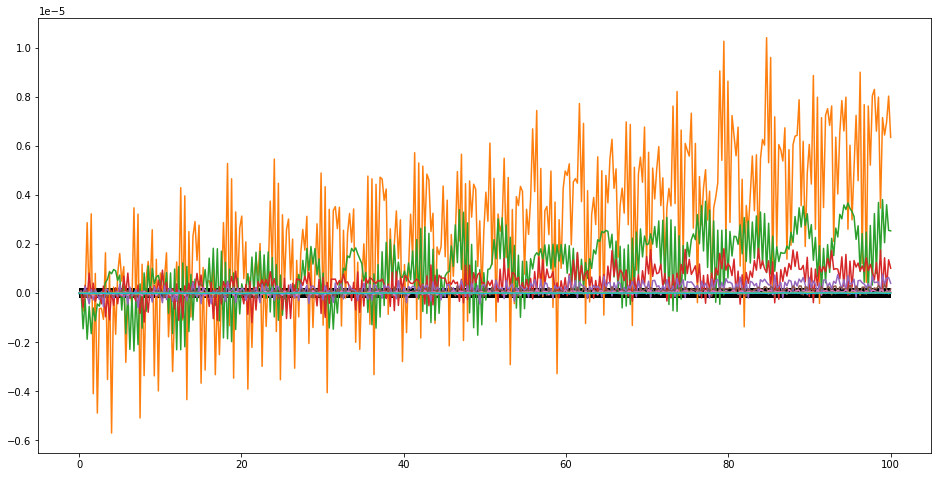

In [103]:
# Variation on the above where we look at the diffs in radius as we decrease integration tolerance.

t0 = 0
T = 100
Nt = 400
r0 = 2.8
ts = np.linspace(t0, T, Nt)

tols = np.logspace(-6.0, -9.0, num=10)

fig = plt.figure(figsize=(16, 8))
ax = plt.gca()

old_rads = np.nan * np.zeros(Nt)

for tind, tol in enumerate(tols):
    print(tind, end=', ')
    v0 = velocity_for_circular_orbit(r0)
    pt0 = [r0, 0, 0, v0]

    sol = integrate.solve_ivp(fun=asteroid_ode, t_span=[t0, T], y0=pt0, t_eval=ts, atol=tol, rtol=tol, method='DOP853')
    
    rads = np.array([np.sqrt(sol.y[0, ind]**2 + sol.y[1, ind]**2) for ind in range(len(ts))])
    
    plt.plot(ts, rads - old_rads)
    
    old_rads = rads
    
ax.hlines(0, ts[0], ts[-1], 'k', lw=10)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

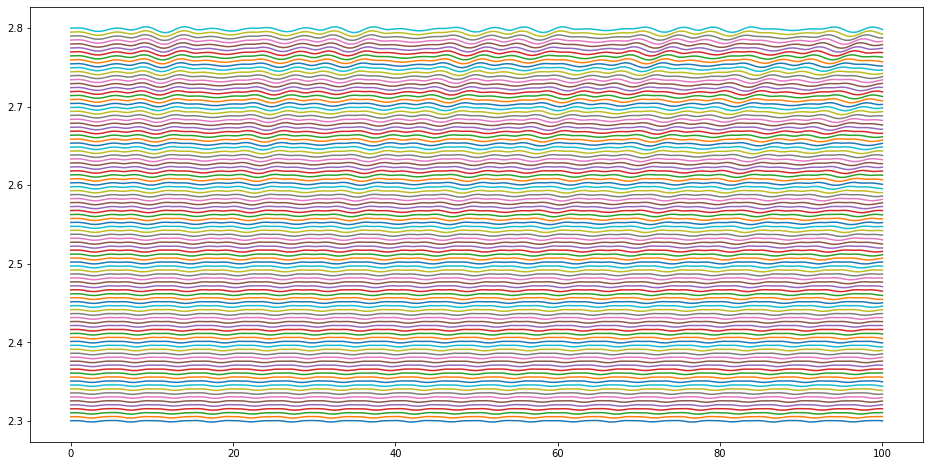

In [104]:
t0 = 0
T = 100
Nt = 200
r0s = np.linspace(2.3, 2.8, 100)
ts = np.linspace(t0, T, Nt)

atol=10**-8
rtol=10**-8

plt.figure(figsize=(16, 8))

for rind, r0 in enumerate(r0s):
    print(rind, end=', ')
    v0 = velocity_for_circular_orbit(r0)
    pt0 = [r0, 0, 0, v0]

    sol = integrate.solve_ivp(fun=asteroid_ode, t_span=[t0, T], y0=pt0, t_eval=ts, method='DOP853', atol=atol, rtol=rtol)
    
    rads = [np.sqrt(sol.y[0, ind]**2 + sol.y[1, ind]**2) for ind in range(len(ts))]
    plt.plot(ts, rads)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 

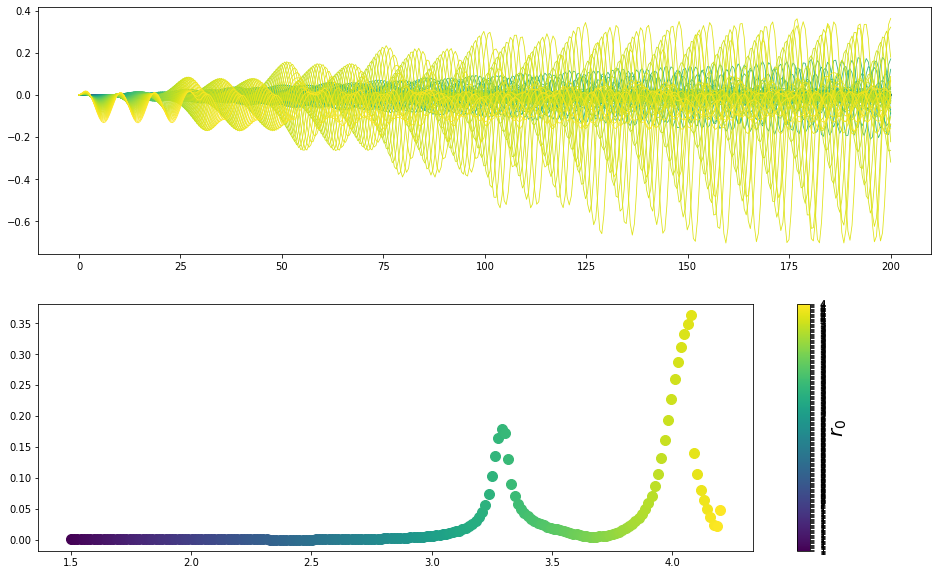

In [120]:
# Try again with fancy coloring
import matplotlib.colors as mcolors
import matplotlib.cm as cm

t0 = 0
T = 200
Nt = 400
r0s = np.linspace(1.5, 4.2, 200)
ts = np.linspace(t0, T, Nt)

colorparams = r0s
# Choose a colormap
colormap = cm.viridis
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

atol=10**-9
rtol=10**-9

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

for rind, r0 in enumerate(r0s):
    print(rind, end=', ')
    v0 = velocity_for_circular_orbit(r0)
    pt0 = [r0, 0, 0, v0]

    sol = integrate.solve_ivp(fun=asteroid_ode, t_span=[t0, T], y0=pt0, t_eval=ts, method='DOP853', atol=atol, rtol=rtol)
    
#     rads = [np.sqrt(sol.y[0, ind]**2 + sol.y[1, ind]**2) for ind in range(len(ts))]
    rads = [np.sqrt(sol.y[0, ind]**2 + sol.y[1, ind]**2) - r0 for ind in range(len(ts))]
    
    color = colormap(normalize(r0))
    
    ax[0].plot(ts, rads, lw=0.8, c=color)
    
    ax[1].scatter(r0, np.max(rads), s=100, c=[color]) # color in a list so we don't get yelled at
    
# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(colorparams)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (colorparams[1] - colorparams[0])/2.0
boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

# Use this to emphasize the discrete color values
# cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

# Use this to show a continuous colorbar
cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')

cbarlabel = r'$r_0$'
cbar.set_label(cbarlabel, fontsize=20)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

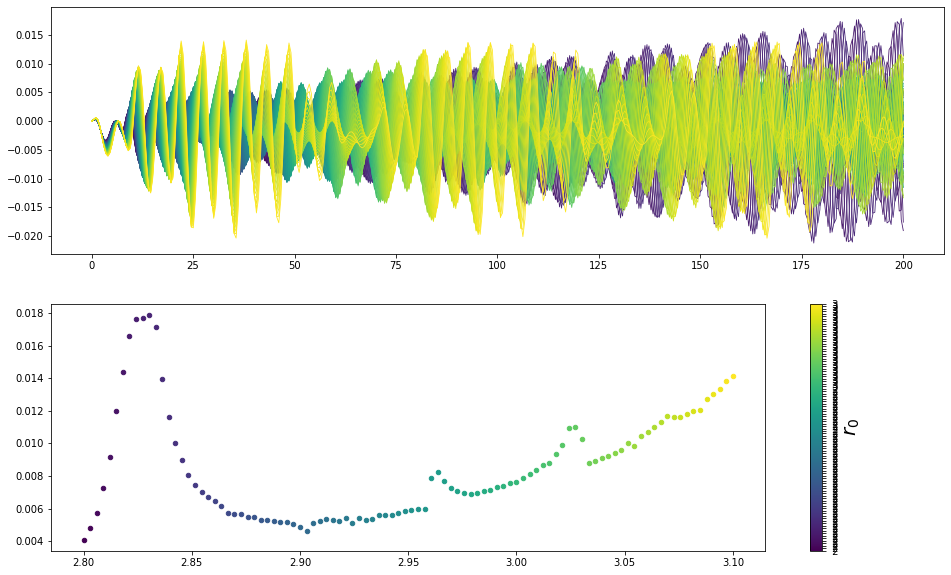

In [9]:
# Focus in on the 3:1 resonance at 2.5 AU
import matplotlib.colors as mcolors
import matplotlib.cm as cm

t0 = 0
T = 200
Nt = 400
r0s = np.linspace(2.8, 3.1, 100)
# r0s = np.linspace(1.9, 3.5, 200)
ts = np.linspace(t0, T, Nt)

colorparams = r0s
# Choose a colormap
colormap = cm.viridis
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

atol=10**-9
rtol=10**-9

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

for rind, r0 in enumerate(r0s):
    print(rind, end=', ')
    v0 = velocity_for_circular_orbit(r0)
    pt0 = [r0, 0, 0, v0]

    sol = integrate.solve_ivp(fun=asteroid_ode, t_span=[t0, T], y0=pt0, t_eval=ts, method='DOP853', atol=atol, rtol=rtol)
    
#     rads = [np.sqrt(sol.y[0, ind]**2 + sol.y[1, ind]**2) for ind in range(len(ts))]
    rads = [np.sqrt(sol.y[0, ind]**2 + sol.y[1, ind]**2) - r0 for ind in range(len(ts))]
    
    color = colormap(normalize(r0))
    
    ax[0].plot(ts, rads, lw=0.8, c=color)
    
    ax[1].scatter(r0, np.max(rads), s=20, c=[color]) # color in a list so we don't get yelled at
    
# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(colorparams)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (colorparams[1] - colorparams[0])/2.0
boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

# Use this to show a continuous colorbar
cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')

cbarlabel = r'$r_0$'
cbar.set_label(cbarlabel, fontsize=20)

### TRY:

- Play with different solvers.
- It would be interesting to try a home-made symplectic integrator.
- Is this a stiff or non-stiff problem?
- We have access to the analytic form of the force so we can provide a Jacobian function.
- Jupiter moves in an elliptical orbit - does this make a difference? maybe it is helpful for some symmetry-breaking (e.g. if an instability is rather mild).
- Jupiter's orbit has a modest angle with the ecliptic plane - we could build this in.
- Our asteroids start with an initial condition that would be circular orbits without the presence of Jupiter.
- Would it be wise to accommodate the presence of Jupiter in this IC?
- Should we look at an IC ball in phase space?
- Are asteroid orbits circular? or elliptical?
- How should we determine when an asteroid has been cleared?
- Do asteroids collide with each other? Is this collision an important mechanism for gap clearing?
- Do they interact with other planets and get further yanked out of orbit?
- Do they need to be seen to shift by several AU before we call them "gone"?
- What is the time-scale thought to be for this gap-clearing process?
- Set up a 2D / heatmap version of the "max-excursion" plot. Instead of varying just r0, we could also vary v0. ... 3D??
- rebound: Redo the whole project with the package rebound.


In [ ]:
# Find the inner and outer orbital radii for the asteroid belt.
# Initialize many independent asteroids at various radii within this range and evolve.

In [ ]:
# Plot radius vs time for each asteroid (together).
